### Import

In [1]:
# Standard libraries
import os
from scipy.optimize import curve_fit, root
from sklearn.metrics import r2_score, auc
from scipy import stats
from scipy.signal import deconvolve
import numpy as np
import numpy.ma as ma
import pandas as pd

# Plotting and image libraries
from matplotlib import pyplot as plt, style
import matplotlib as mpl
import matplotlib.image as mpimg
from scipy.optimize import curve_fit

# # Custom libraries
# import frgtools.misc as frgm
# from frgtools.curveprocessing import gaussian

# Other utilities
from natsort import natsorted
from tqdm import tqdm
# import ruptures as rpt

# OpenCV
import cv2
import numpy as np
from tqdm import tqdm
import plotly.express as px

# Jupyter notebook settings
%config InlineBackend.figure_format = 'retina'
from scipy.ndimage import gaussian_filter

# Style settings
style.use('ggplot')  # or plt.style.use('ggplot')
mpl.rcParams.update(mpl.rcParamsDefault)

# Color choice
color_choice = ['#F8DDA4', '#C8D5B9', '#68B0AB', '#4A7C59'][::-1]

### Load Functions

In [25]:
def modified_z_score(intensity):
    median_int = np.median(intensity)
    mad_int = np.median([np.abs(intensity -median_int)])
    modified_z_scores = 0.6745 * (intensity- median_int) / mad_int
    return modified_z_scores

def fixer(y,m=3, th=7):
    try:
        th = 7 # binarization threshold. 
        spikes = abs(np.array(modified_z_score(np.diff(y)))) > th
        y_out = y.copy() # So we don’t overwrite y
        for i in np.arange(len(spikes)):
            if spikes[i] != 0: # If we have an spike in position i
                w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
                w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_out[i] = np.mean(y[w2]) # and we average their values
    except:
        m = 1
        th = 7 # binarization threshold. 
        spikes = abs(np.array(modified_z_score(np.diff(y)))) > th
        y_out = y.copy() # So we don’t overwrite y
        for i in np.arange(len(spikes)):
            if spikes[i] != 0: # If we have an spike in position i
                w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
                w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_out[i] = np.mean(y[w2]) # and we average their values        
 
    return y_out

RGB_SCALE = 255
CMYK_SCALE = 100


def rgb_to_cmyk(r, g, b):
    if (r, g, b) == (0, 0, 0):
        # black
        return 0, 0, 0, CMYK_SCALE

    # rgb [0,255] -> cmy [0,1]
    c = 1 - r / RGB_SCALE
    m = 1 - g / RGB_SCALE
    y = 1 - b / RGB_SCALE

    # extract out k [0, 1]
    min_cmy = min(c, m, y)
    c = (c - min_cmy) / (1 - min_cmy)
    m = (m - min_cmy) / (1 - min_cmy)
    y = (y - min_cmy) / (1 - min_cmy)
    k = min_cmy

    # rescale to the range [0,CMYK_SCALE]
    return c * CMYK_SCALE, m * CMYK_SCALE, y * CMYK_SCALE, k * CMYK_SCALE
# test = df['img'][6][300,:,:,:]/255

def rgb_to_cmyk(rgb):
	r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]
	k = 1 - np.max(rgb, axis=-1)
	c = (1-r-k)/(1-k)
	m = (1-g-k)/(1-k)
	y = (1-b-k)/(1-k)
	return np.dstack([c, m, y, k])

def rgb_to_cmyk_2(rgb):
	with np.errstate(invalid='ignore', divide='ignore'):
		K = 1 - np.max(test, axis=2)
		C = (1-test[...,0] - K)/(1-K)
		M = (1-test[...,1] - K)/(1-K)
		Y = (1-test[...,2] - K)/(1-K)
	return np.dstack([C, M, Y, K])

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def remove_inf(x, y):
    mask = ~np.isinf(x) & ~np.isinf(y)
    x = x[mask]
    y = y[mask]
    return x, y

def linear(t, b, m):
    y = m*t + b
    return (y)

def avrami(t, k, n):
    y = 1 - np.exp(-k*(t)**n)
    return (y)

def JMAK(t, e, k, n):
    R = 8.314 #J/mol/K
    T = 273.15+230 #K
    t0=0
    y = 1 - np.exp(-(k*np.exp(-e/(R*T))*(t-t0))**n)
    return (y)

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]


# Define the RGB to CMYK conversion function
def rgb_to_cmyk(rgb):
    r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]
    k = 1 - np.max(rgb, axis=-1)
    c = (1-r-k)/(1-k)
    m = (1-g-k)/(1-k)
    y = (1-b-k)/(1-k)
    return np.dstack([c, m, y, k])

# Function to calculate the K (black) mean for a video matrix
# def calculate_K_mean(vm):
#     # Convert each frame to CMYK and calculate the mean of the K channel
#     return [1-np.mean(rgb_to_cmyk(vm[frame, :, :, :]/255)[:,:,3]) for frame in range(vm.shape[0])]

# Apply the function to the 'VM' column of the DataFrame
# all_samples_df['K_mean'] = all_samples_df['VM'].apply(calculate_K_mean)



def calculate_K_mean(vm):
    K_means = []
    for frame in range(vm.shape[0]):
        # Convert the frame to CMYK
        cmyk_image = rgb_to_cmyk(vm[frame, :, :, :]/255)
        
        # Extract the K channel
        K_channel = cmyk_image[:,:,3]
        
        # Calculate the 2.5th and 97.5th percentiles (95% CI)
        ci_low, ci_high = np.percentile(K_channel, [2.5, 97.5])
        
        # Mask the values outside the CI
        masked_K_channel = np.ma.masked_outside(K_channel, ci_low, ci_high)
        
        # Calculate the mean of the values within the CI
        K_mean = np.ma.mean(masked_K_channel)
        
        K_means.append(K_mean)
        
    return K_means


def calculate_cv(values):
    mean_value = np.nanmean(values)
    std_dev = np.nanstd(values)
    cv = (std_dev / mean_value) * 100 if mean_value != 0 else 0
    return cv



def calculate_auc(time_axis, values):
    normalized_values = values / np.nanmax(values)
    return auc(time_axis, normalized_values)


def calculate_k_vm(vm):
    return np.array([rgb_to_cmyk(frame) for frame in vm])

def calculate_K_delta(values):
    return values[0] - values[-1]



def process_video(fids, output_path, export_video=True, return_matrix=False, apply_stabilization=True, fps=60, interval=10, crop_x0=500, crop_x1=3850, crop_y0=500, crop_y1=5000):
    Full_frame = slice(crop_x0, crop_x1), slice(crop_y0, crop_y1) #TODO change this w.r.t. your video size, this crops the video, basically crop this to your hot plate or whatever


    size = (Full_frame[1].stop-Full_frame[1].start, Full_frame[0].stop-Full_frame[0].start)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    out = None
    if export_video:
        out = cv2.VideoWriter(output_path, fourcc, fps, frameSize=size)
        if not out.isOpened():
            print("Error: VideoWriter didn't open")
            return None
    
    ref_img = cv2.imread(fids[0])
    if ref_img is None:
        print("Error reading reference image")
        return None
    
    ref_img_cropped = ref_img[Full_frame]
    ref_img_cropped_gray = cv2.cvtColor(ref_img_cropped, cv2.COLOR_BGR2GRAY)
    
    mask = np.ones_like(ref_img_cropped_gray, dtype=np.uint8)
    
    num_frames = (len(fids) - 1) // interval
    video_matrix = np.zeros((num_frames, size[1], size[0], 3), dtype=np.uint8) if return_matrix else None
    
    counter = 0
    
    for n in tqdm(range(0, num_frames * interval, interval)):
        temp = cv2.imread(fids[n])
        if temp is None:
            continue
        
        cropped_temp = temp[Full_frame]
        cropped_temp_gray = cv2.cvtColor(cropped_temp, cv2.COLOR_BGR2GRAY)
        
        if apply_stabilization:
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-6)
            _, warp_matrix = cv2.findTransformECC(ref_img_cropped_gray, cropped_temp_gray, warp_matrix, cv2.MOTION_EUCLIDEAN, criteria, inputMask=mask, gaussFiltSize=5)
            aligned_temp = cv2.warpAffine(cropped_temp, warp_matrix, (size[0], size[1]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
            
        # if apply_stabilization:
        #     warp_matrix = np.eye(2, 3, dtype=np.float32)  # Initialize the warp matrix as an identity matrix
        #     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-6)
            
        #     # Use cv2.MOTION_AFFINE instead of cv2.MOTION_EUCLIDEAN
        #     _, warp_matrix = cv2.findTransformECC(ref_img_cropped_gray, cropped_temp_gray, warp_matrix, cv2.MOTION_AFFINE, criteria, inputMask=mask, gaussFiltSize=5)
            
        #     aligned_temp = cv2.warpAffine(cropped_temp, warp_matrix, (size[0], size[1]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        else:
            aligned_temp = cropped_temp
        
        if export_video:
            out.write(aligned_temp)
        
        if return_matrix:
            video_matrix[counter] = aligned_temp
            counter += 1
    
    if export_video:
        out.release()
    
    cv2.destroyAllWindows()
    
    if return_matrix:
        return video_matrix
    


def apply_perspective_transform(frame, M, cols, rows):
    return cv2.warpPerspective(frame, M, (cols, rows))


def fit_data_and_find_x_intercept(K_mean, frame_axis, start=2000, stop=3000, sigma=15):
    if K_mean is None or np.isnan(K_mean).all():
        return None

    K_mean_array = np.array(K_mean)
    K_mean_array = K_mean_array[~np.isnan(K_mean_array)]
    # sigma = 15

    smoothed_norm_k_mean_values = gaussian_filter(K_mean_array, sigma) / np.nanmax(K_mean_array)
    
    frame_axis_array = np.array(frame_axis)[:len(K_mean_array)]
    mask = (frame_axis_array >= start) & (frame_axis_array <= stop)
    fit_x = frame_axis_array[mask]
    fit_y = 1 - smoothed_norm_k_mean_values[mask]

    coefficients = np.polyfit(fit_x, fit_y, 1)
    slope, intercept = coefficients

    x_intercept = -intercept / slope if slope != 0 else None

    return x_intercept

### Get your data

In [3]:
image_folder_0 = 'test_images/'

In [4]:
all_files = os.listdir(image_folder_0)
# Filter the files based on your conditions
fids_0 = []
for f in all_files:
    if 'control' not in f or '_rgb' in f:
        fids_0.append(image_folder_0 + f)
fids_0 = natsorted(fids_0)
print(len(fids_0))

9


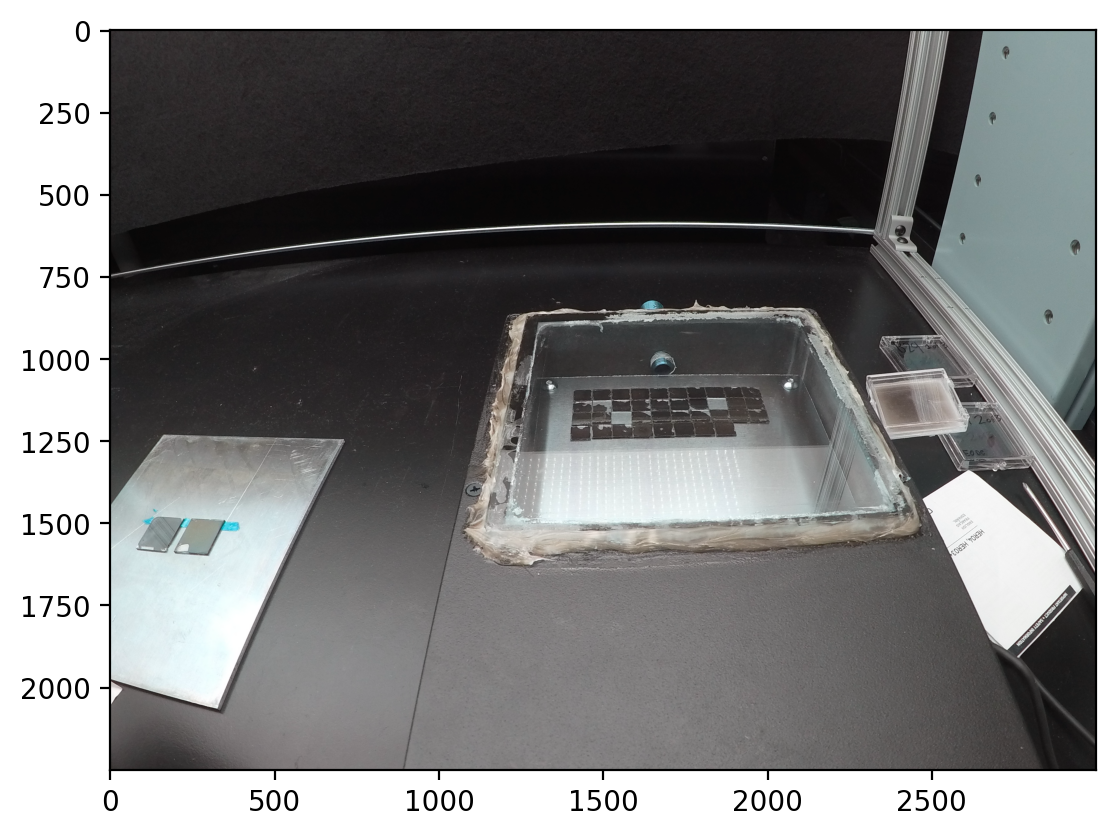

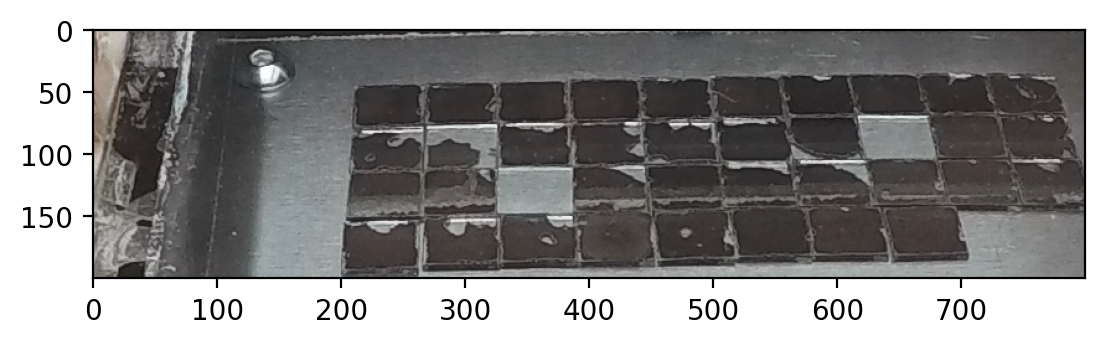

In [76]:
# first figure out the cropping to the full spread of samples range
temp = cv2.imread(fids_0[0])
plt.imshow(temp)
plt.show()
plt.imshow(temp[1050:1250, 1200:2000])
plt.show()

In [79]:
output_path = "test_video/"
video_matrix = process_video(fids_0, output_path, fps=30, interval=1, export_video=False, return_matrix=True, apply_stabilization=True, crop_x0=500, crop_x1=1250, crop_y0=1200, crop_y1=2000)
# change interval here according to the # of images in the file

100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


In [80]:
video_matrix.size*video_matrix.itemsize/1e9 # GB

0.0144

In [81]:
# import h5py

# # Save the video_matrix as h5 if over 4GB
# with h5py.File('T33.h5', 'w') as f:
#     f.create_dataset('video_matrix', data=video_matrix)

In [10]:
# import h5py

# # Load the video_matrix
# with h5py.File('b29-b31_VM.h5', 'r') as f:
#     video_matrix = f['video_matrix'][:]

In [11]:
# import pickle as pkl

# with open('b29-b31_VM.pkl', 'wb') as f:
#     pkl.dump(video_matrix, f)


In [12]:
# import pickle as pkl

# with open('b29-b31_VM.pkl', 'rb') as f:
#     video_matrix = pkl.load(f)


In [13]:
# import cv2

# def write_video_from_matrix(video_matrix, output_path, fps=60):
#     # Get the shape of the video_matrix
#     num_frames, height, width, _ = video_matrix.shape
    
#     # Define the codec and create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
#     if not out.isOpened():
#         print("Error: VideoWriter didn't open")
#         return
    
#     # Write each frame to the video
#     for i in range(num_frames):
#         out.write(video_matrix[i])
    
#     # Release the VideoWriter
#     out.release()
#     print(f"Video written to {output_path}")

# # Example usage
# output_path = '/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/Tandem_project/GoPro_Analysis/20230814_B29/output_video/B29_r2_stabilized_transformed.avi'
# write_video_from_matrix(video_matrix, output_path)


In [82]:


# Define the points in the original image (corners of the original image)
rows, cols = video_matrix.shape[1:3]
pts1 = np.float32([[769, 79], [3796, 35], [387, 3295], [4328, 3274]])  # top left, top right, bottom left, bottom right

# Define the magnitude of the transformation (e.g., 0.05 for a 5% stretch at the top)
magnitude = 0.1

# Define where those points will be in the transformed image (stretching the top)
pts2 = np.float32([[0, -rows * magnitude], [cols - 1, -rows * magnitude], [0, rows - 1], [cols - 1, rows - 1]])

# Compute the perspective transformation matrix
M = cv2.getPerspectiveTransform(pts1, pts2)

# Get the first original image from video_matrix
original_image = video_matrix[0, :, :, 1]

# Apply the transformation to the first frame to see what it looks like
transformed_image = apply_perspective_transform(original_image, M, cols, rows)

# # Display the original image using Plotly Express
# fig_original = px.imshow(original_image)
# fig_original.show()

# # Display the transformed image using Plotly Express
# fig_transformed = px.imshow(transformed_image)
# fig_transformed.show()

# # If the transformed image looks good, uncomment the following lines to apply the transformation to the whole video_matrix
for i in tqdm(range(video_matrix.shape[0])):
    video_matrix[i, :, :, :] = apply_perspective_transform(video_matrix[i, :, :, :], M, cols, rows)

100%|██████████| 8/8 [00:00<00:00, 437.32it/s]


In [83]:


# Create a blank matrix with placeholders for 64 samples in a format similar to center_points_0


# Create an 8x8 blank matrix with placeholders (None) for each sample
center_points_0 = np.array([
    [(1612, 389), (2747, 389)],
    [(1612, 1221), (2747, 1221)],
    [(1612, 2053), (2747, 2053)],
    [(1612, 2896), (2747, 2896)],

])

# sample_names_0 = np.arange(63, -1, -1).reshape(8, 8)
# Lookup table
sample_names_0 = np.array([ [10, 110],
                            [5, 15],
                            [1, 11],
                            [0, 10],])





C:\Users\aryan\AppData\Local\Temp\ipykernel_7808\102920677.py:17: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



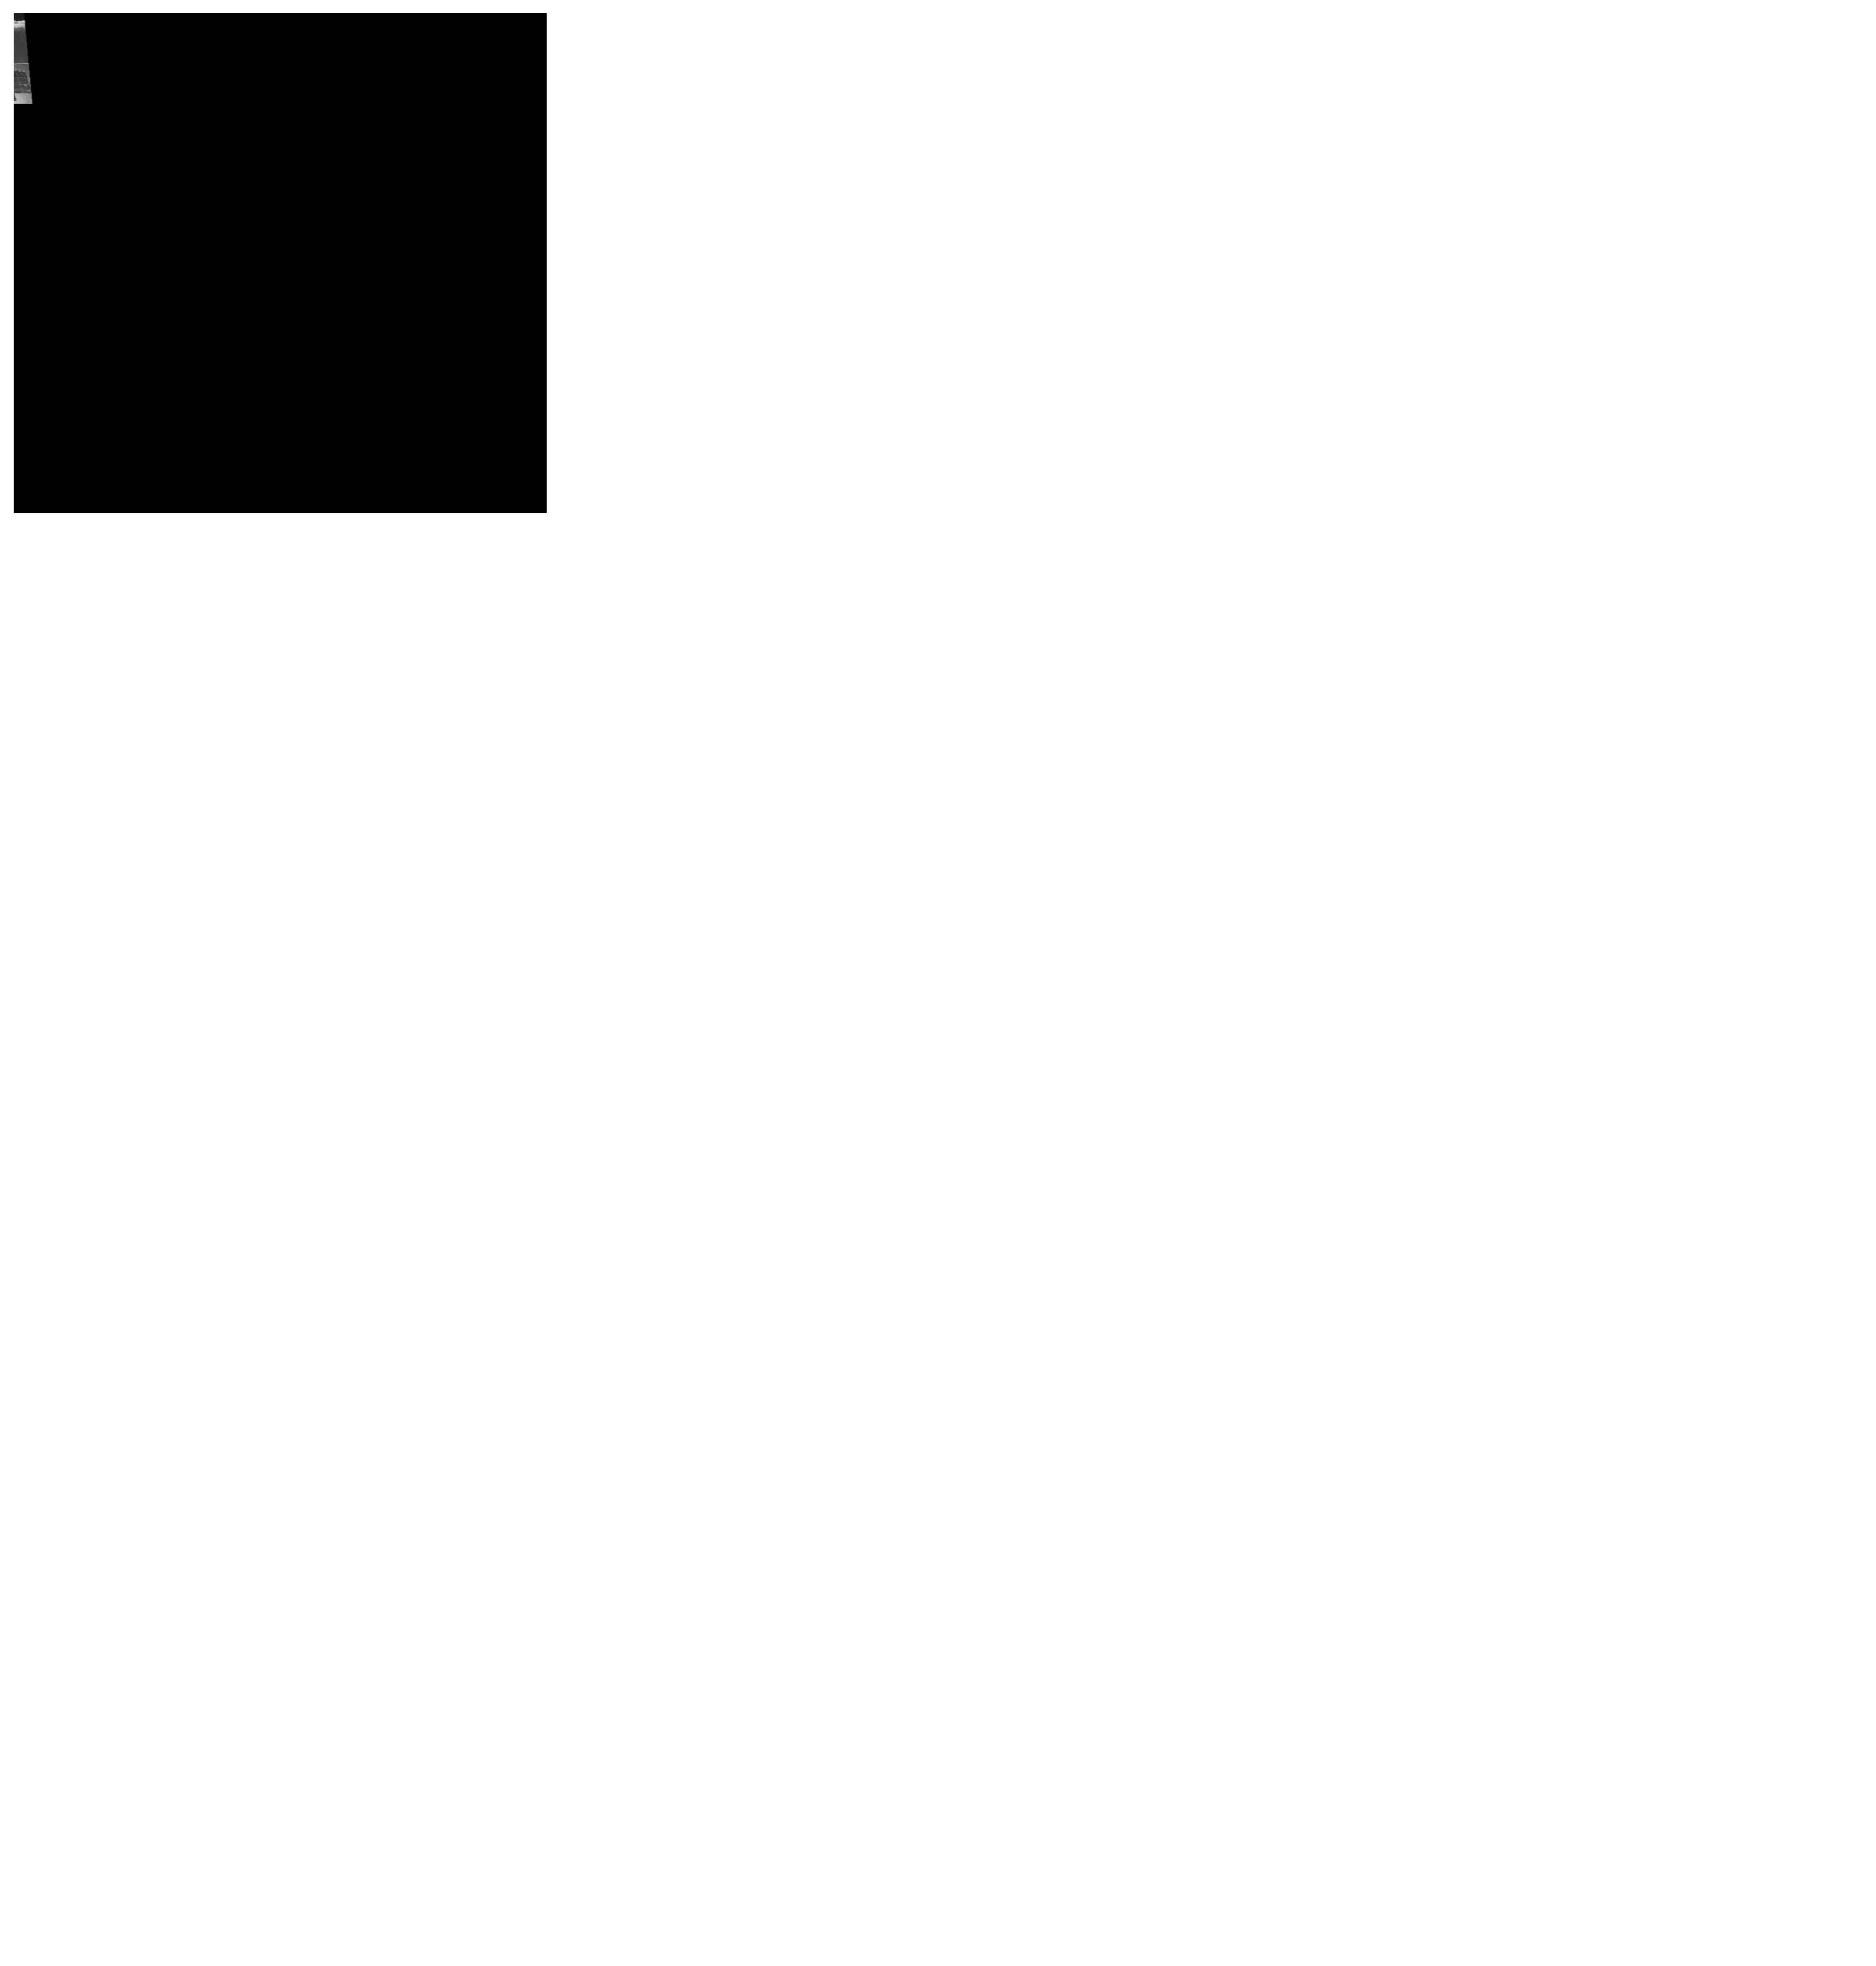

In [84]:
# Display the original or transformed image
ax, fig = plt.subplots(figsize=(5, 5))
plt.imshow(transformed_image, cmap='gray')

# Loop through sample_names_0 and center_points_0 to annotate the image
for i in range(center_points_0.shape[0]):
    for j in range(center_points_0.shape[1]):
        x, y = center_points_0[i, j]
        sample_name = sample_names_0[i, j]
        
        # Annotate the image
        plt.text(x, y, str(sample_name), color='white', fontsize=10, ha='center', va='center')

# Show the image with annotations
plt.axis('off')
# make it tight
plt.tight_layout()
plt.show()


In [ ]:
# drop noisy section of data if not reasonably repairable

# video_matrix = np.concatenate([video_matrix[:2700], video_matrix[2901:]], axis=0)


In [43]:
# Define the window size (70 pixels in x and y)
window_size = 250
num_frames = video_matrix.shape[0]

# Create a slice matrix to hold the slices
slice_shape = (2 * window_size, 2 * window_size, video_matrix.shape[3])
slice_matrix = np.empty((*sample_names_0.shape, *slice_shape))

# Extract the slices from the video_matrix using the center points
for i in range(sample_names_0.shape[0]):
    for j in range(sample_names_0.shape[1]):
        x, y = center_points_0[i, j]

        # Boundary checks
        x_min = max(0, x - window_size)
        x_max = min(video_matrix.shape[2], x + window_size)
        y_min = max(0, y - window_size)
        y_max = min(video_matrix.shape[1], y + window_size)

        temp_slice = video_matrix[0, y_min:y_max, x_min:x_max, :]

        # Padding in case the slice is smaller than the window
        pad_x_min = window_size - (x - x_min)
        pad_x_max = window_size + (x_max - x)
        pad_y_min = window_size - (y - y_min)
        pad_y_max = window_size + (y_max - y)

        slice_matrix[i, j, pad_y_min:pad_y_max, pad_x_min:pad_x_max, :] = temp_slice


In [44]:
import pandas as pd

# Create a list to hold the data for each sample
samples_data = []

# Iterate through the samples in the slice_matrix
for i in tqdm(range(slice_matrix.shape[0])):
    for j in range(slice_matrix.shape[1]):
        # Extract the sample name
        sample_name = sample_names_0[i, j]

        # Create a new video matrix for the current sample
        sample_video_matrix = np.empty((num_frames, *slice_shape))

        # Extract the slices for the current sample from the video_matrix
        for frame in range(num_frames):
            x, y = center_points_0[i, j]
            if np.isnan(x) or np.isnan(y):
                continue # Skip if x or y is NaN
            x, y = int(x), int(y)

            # Check that the coordinates are within valid bounds
            if x - window_size < 0 or x + window_size >= video_matrix.shape[2] or y - window_size < 0 or y + window_size >= video_matrix.shape[1]:
                continue # Skip if coordinates are too close to the edges

            sample_video_matrix[frame] = video_matrix[frame, y-window_size:y+window_size, x-window_size:x+window_size, :]

        # Append the current sample's data to the list
        samples_data.append((sample_name, sample_video_matrix))



# Create a DataFrame from the list of samples data
all_samples_df = pd.DataFrame(samples_data, columns=['sample', 'VM'])

# You now have a DataFrame (all_samples_df) that contains the sample names and video matrices for all samples


100%|██████████| 4/4 [00:00<00:00, 25.05it/s]


In [46]:
all_samples_df['K_VM'] = all_samples_df['VM'].apply(calculate_k_vm)

all_samples_df['RGB_mean'] = all_samples_df['VM'].apply(
    lambda vm: [np.mean(vm[frame, :, :, :], axis=(0, 1)) for frame in range(vm.shape[0])]
)
time_axis = [frame * 5*100 / 60**2 for frame in range(len(all_samples_df.loc[0, 'RGB_mean']))] # in hours: 120 is the camera picture interval in seconds * 10 for the interval of 10
frame_axis = [frame for frame in range(len(all_samples_df.loc[0, 'RGB_mean']))]

# Apply the function to the 'VM' column of the DataFrame
all_samples_df['K_mean'] = all_samples_df['VM'].apply(calculate_K_mean)
# all_samples_df['cv'] = all_samples_df['RGB_mean'].apply(calculate_cv)
# all_samples_df['auc'] = all_samples_df['K_mean'].apply(lambda x: calculate_auc(time_axis,x))

all_samples_df['K_delta'] = all_samples_df['K_mean'].apply(calculate_K_delta)



In [36]:
# all_samples_df['x_intercept'] = all_samples_df['K_mean'].apply(
#     fit_data_and_find_x_intercept, 
#     args=(frame_axis, 5, 18, 2)
# )
# # fitting needs work 

In [ ]:
# # Specify the sample values you're interested in
# samples_to_nan = [47, 46, 45, 36, 17]

# # Set all other column values to NaN for these samples
# all_samples_df.loc[all_samples_df['sample'].isin(samples_to_nan), 'VM':'K_delta'] = np.nan


C:\Users\aryan\AppData\Local\Temp\ipykernel_7808\2811486764.py:16: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\aryan\AppData\Local\Temp\ipykernel_7808\2811486764.py:16: RuntimeWarning:

invalid value encountered in true_divide



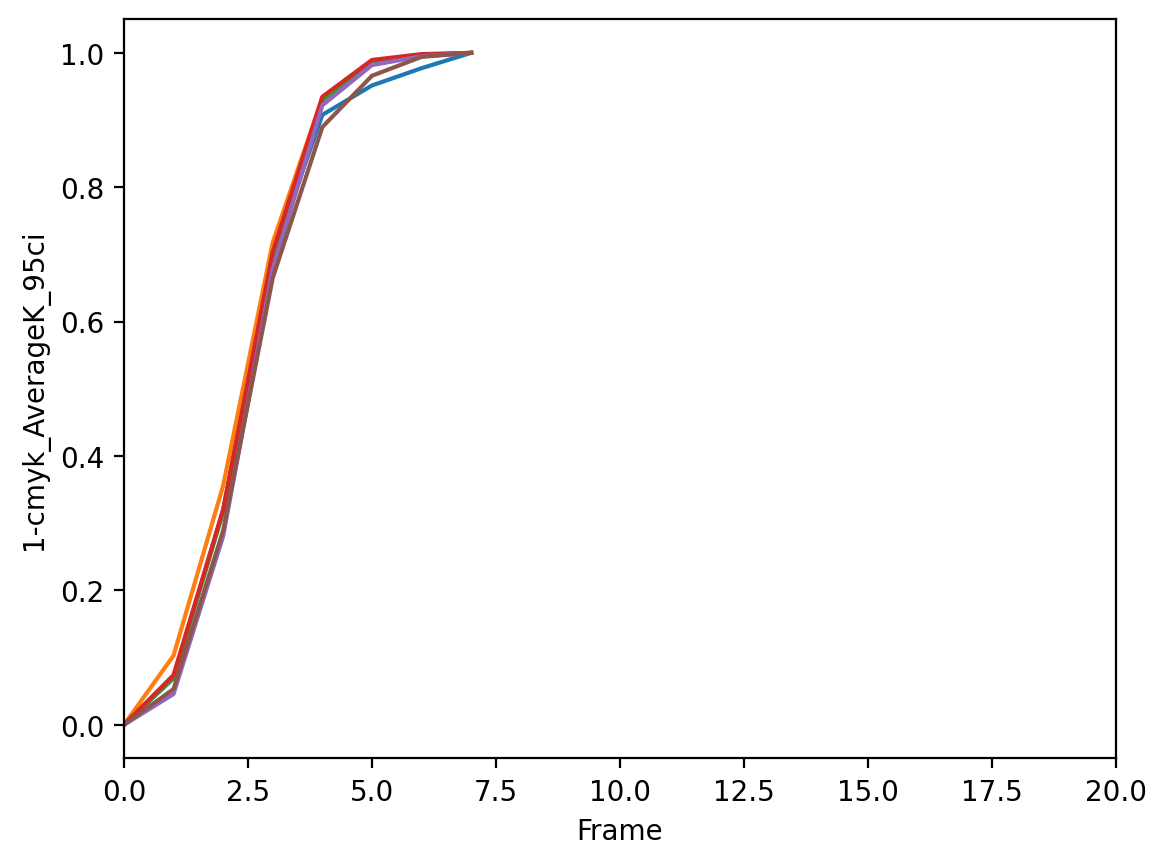

In [57]:
from matplotlib.ticker import MultipleLocator
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np

filtered_df = all_samples_df.dropna(subset=['K_mean'])

sigma = 1

color_data = []

# Your existing code for plotting
for index, row in filtered_df.iterrows():
    k_mean_values = row['K_mean']
    smoothed_norm_k_mean_values = gaussian_filter(k_mean_values, sigma) / np.nanmax(gaussian_filter(k_mean_values, sigma)) - (np.nanmin(gaussian_filter(k_mean_values, sigma)) / np.nanmax(gaussian_filter(k_mean_values, sigma)))
    smoothed_norm_k_mean_values = smoothed_norm_k_mean_values/np.nanmax(smoothed_norm_k_mean_values)

    color_data.append(smoothed_norm_k_mean_values)
    # smoothed_norm_k_mean_values = gaussian_filter(k_mean_values, sigma) / np.nanmax(k_mean_values)
    plt.plot(frame_axis, 1-smoothed_norm_k_mean_values, alpha=1)


# add a vertical line
# plt.axvline(x=2700, color='k', linestyle='--', linewidth=1)
# plt.axvline(x=2900, color='k', linestyle='--', linewidth=1)
# Set major ticks at intervals of 24
ax = plt.gca()
# ax.xaxis.set_major_locator(MultipleLocator(24))

# Set minor ticks at intervals of 6
# ax.xaxis.set_minor_locator(MultipleLocator(6))

plt.xlim(0, 20)
# plt.ylim(0, .6)
plt.xlabel('Frame')
plt.ylabel('1-cmyk_AverageK_95ci')
plt.show()


#the next resonable step would be to fit the linear portion of these 'S' shape curves to get an onset value to further dimensionality reduce.
## Note samples that did not degrade by end of test look odd, e.g. max value will not be at end of measurement, 

In [59]:
color_data
# observation: each array corresponds to a single sample as its hard coded in the lookup table. 8 frames long

[array([1.        , 0.93070345, 0.68013293, 0.30315169, 0.09229089,
        0.04857743, 0.02285396, 0.        ]),
 array([1.        , 0.89702171, 0.64419383, 0.28219869, 0.06703072,
        0.01478716, 0.00286525, 0.        ]),
 array([1.        , 0.93008518, 0.68347372, 0.30086603, 0.07067885,
        0.0161635 , 0.0034591 , 0.        ]),
 array([1.        , 0.92586709, 0.6798837 , 0.29672285, 0.06534447,
        0.01059939, 0.00185354, 0.        ]),
 array([1.        , 0.95422017, 0.71933083, 0.32199369, 0.07815951,
        0.0182131 , 0.00514074, 0.        ]),
 array([1.        , 0.94669639, 0.71095337, 0.33506902, 0.11046418,
        0.03413201, 0.00602077, 0.        ]),
 array([nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan])]

## Extra Scratch work

#### Extra: To make a color bar out of images